In [288]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
%matplotlib inline
np.set_printoptions(suppress=True)

In [289]:
categories = None  # ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [294]:
TOKEN_PAT = r'\b[^(\W|\d|_)]{1,}\w\w+\b'
cnt_vecr = CountVectorizer(stop_words='english', min_df=0.005, max_df=0.2, token_pattern=TOKEN_PAT)
dtm = cnt_vecr.fit_transform(newsgroups_train.data)
print('{} documents'.format(dtm.shape[0]))

good_ics = np.where((dtm > 0).sum(axis=1) > 10)[0]
good_newsgroup_data = [newsgroups_train.data[i] for i in good_ics]  # no pointless docs in training
dtm = cnt_vecr.fit_transform(good_newsgroup_data)
dtm[dtm > 10] = 10  # no pointless word counts
print('{} useful documents'.format(dtm.shape[0]))

vectors_tfidf = TfidfTransformer().fit_transform(dtm)
vocab = cnt_vecr.get_feature_names()
P_term = dtm.sum(axis=0) / dtm.sum()
print('{} terms in vocab'.format(len(vocab)))

# vectorizer_tfidf = TfidfVectorizer(stop_words='english', min_df=0.001, max_df=0.5)
# vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)
# vocab = np.array(vectorizer_tfidf.get_feature_names())

11314 documents
8436 useful documents
2761 terms in vocab


### present topics by relevant words
- from pyldavis, but footnote 2 there is incorrect
- https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [242]:
num_top_words=15

def show_topics(topic_term_mat, P_term=P_term, vocab=vocab, lbd=1):
    # use weighting scheme from pyldavis
    a = np.asarray(
        lbd * np.log1p(topic_term_mat) + \
        (1 - lbd) * np.log1p(np.multiply(topic_term_mat, 1 / P_term.reshape(1, -1)))
    )
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = [top_words(t) for t in a]
    topic_list = [' '.join(t) for t in topic_words]
    for i, t in enumerate(topic_list):
        print('{:2d}: {}'.format(i, t))
    return topic_list

## sklearn NMF

In [243]:
m,n=vectors_tfidf.shape
d=20  # num topics

# beta_loss: 1 = kullback-leibler, 2 = frobenius-norm
clf = decomposition.NMF(n_components=d, random_state=1, solver='mu', beta_loss=2)

%time W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

CPU times: user 1.8 s, sys: 2.75 s, total: 4.56 s
Wall time: 1.28 s


In [244]:
_ = show_topics(H1, lbd=0.8)

 0: really right good say time did things thing gun evidence make life going wrong way
 1: windows dos microsoft norton desktop swap running sys drivers utilities screen font driver shareware disk
 2: game team players games season hockey nhl teams play pitching league player baseball playoffs year
 3: dsl chastity n3jxp geb cadre shameful intellect skepticism pitt surrender gordon banks soon patient patients
 4: key chip clipper encryption keys escrow nsa encrypted algorithm crypto secure phones des wiretap rsa
 5: drive drives floppy disk hard boot ide quantum controller meg motherboard settings external internal bios
 6: god jesus bible christ faith heaven sin lord grace christians eternal kingdom scripture spirit mary
 7: mail email list address send interested mailing fax info reply phone looking post replies book
 8: armenian armenians turkish armenia turkey turks genocide argic serdar muslim soviet greek russian republic massacre
 9: card video vga ati monitor cards diamond driv

## anchor word NMF

In [245]:
from anchors import findAnchors
from sklearn.decomposition.nmf import non_negative_factorization
from sklearn.preprocessing import normalize
from scipy import sparse
import time

In [246]:
class Params:
    def __init__(self, filename):
        self.log_prefix = None
        self.checkpoint_prefix = None
        self.seed = int(time.time())

        with open(filename, "rt") as f:
            for l in f:
                if l == "\n" or l[0] == "#":
                    continue
                l = l.strip()
                l = l.split("=")
                if l[0] == "log_prefix":
                    self.log_prefix = l[1]
                elif l[0] == "max_threads":
                    self.max_threads = int(l[1])
                elif l[0] == "eps":
                    self.eps = float(l[1])
                elif l[0] == "checkpoint_prefix":
                    self.checkpoint_prefix = l[1]
                elif l[0] == "new_dim":
                    self.new_dim = int(l[1])
                elif l[0] == "seed":
                    self.seed = int(l[1])
                elif l[0] == "anchor_thresh":
                    self.anchor_thresh = int(l[1])
                elif l[0] == "top_words":
                    self.top_words = int(l[1])

params = Params('settings.example')

In [247]:
M = dtm.T.tocsc().astype(float)
print('{} words / {} documents'.format(*M.shape))

print("identifying candidate anchors")
candidate_anchors = np.where((M > 0).sum(axis=1) > params.anchor_thresh)[0].tolist()

# # only accept anchors that appear in a significant number of docs
# for i in range(M.shape[0]):
#     if len(np.nonzero(M[i, :])[1]) > params.anchor_thresh:
#         candidate_anchors.append(i)

print(len(candidate_anchors), "candidates")

2761 words / 8436 documents
identifying candidate anchors
1164 candidates


In [263]:
def get_Q(M):
    """
    M: term x document matrix
    """
    doclengths = np.array(M.sum(axis=0))
    H = M.multiply(1 / np.sqrt(np.multiply(doclengths, doclengths - 1) ))
    diags = np.array(M.multiply(1 / np.multiply(doclengths, doclengths - 1)).sum(axis=1)).flatten()
    Q = H.dot(H.T) - sparse.diags(diags)
    assert np.isclose(Q[Q<0], 0).all()
    Q[Q<0] = 0
    return np.asarray((Q / Q.sum()).todense())

Q = get_Q(M)

In [255]:
# # original procedure to compare
# from Q_matrix import generate_Q_matrix
# Q = generate_Q_matrix(M.copy())  # changes input matrix
# np.asarray((get_Q(M) - Q)[:7,:7] * 1000).round(6)

In [256]:
n_topics = 20
assert n_topics < len(candidate_anchors)

# find anchors- this step uses a random projection
# into low dimensional space
anchors = findAnchors(Q, n_topics, params, candidate_anchors)
print("anchors are:")
for i, a in enumerate(anchors):
    print(i, vocab[a])

anchors are:
0 banks
1 scsi
2 picture
3 period
4 mouse
5 pub
6 water
7 motif
8 belief
9 ground
10 window
11 brand
12 food
13 israel
14 vga
15 comp
16 print
17 keys
18 object
19 bus


In [264]:
from fastRecover import nonNegativeRecover
loss = 'KL'  # 'KL' / 'L2'
A_org, topic_likelihoods = nonNegativeRecover(Q, anchors, loss, params)

begin threaded recovery with 3 processors
0	485	0.12751356297601638
1000	152	0.25021723129318213
2000	581	0.2495750969294267


In [266]:
_ = show_topics(A_org.T, lbd=0.8)

 0: geb dsl n3jxp chastity shameful intellect cadre skepticism pitt surrender gordon banks soon patient brain
 1: scsi ide quadra drive drives controller boot quantum pins floppy external cables upgrade simms mac
 2: picture roger till paint inch tube records baseball sports adams converted boys jack filter losing
 3: islanders rangers van toronto detroit wings playoff leafs pittsburgh quebec jersey adams philadelphia montreal boston
 4: mouse button ball desktop driver modem port keyboard ports pins connect annoying gateway bat sys
 5: zip indiana ftp pub shareware directory updated routine helps site latest desktop gif bbs jan
 6: water heat cool oil fuel hot tires gas spare tank nuclear ford engine air odd
 7: motif x11r5 compile greatly core appreciated classes warning hello marc xlib advance replies dale widget
 8: belief kent gods punishment believing cheers christians heaven objective scripture islam god morality christianity bobby
 9: ground ride signals connected rear tank pin

In [269]:
# recover topics
# A, topic_likelihoods = nonNegativeRecover(Q, anchors, loss, params)

P_w = Q.sum(axis=1)
Q_bar = normalize(Q, axis=1, norm='l1')
Q_anchors = Q_bar[anchors, :]  #.toarray()

# compute C such that C * Q_anchors = Q_bar
# all rowsums of this matrix product are 1, for Q_* by construction, for C it follows
#   Q_anchor
# C Q_bar
%time C, _, n_iter = non_negative_factorization(Q_bar, W=None, H=Q_anchors, n_components=n_topics,\
                                                update_H=False, solver='mu', beta_loss=1)

C_n = normalize(C, axis=1, norm='l1')

print('computing C took {} iterations'.format(n_iter))

CPU times: user 11.3 s, sys: 10.2 s, total: 21.5 s
Wall time: 6.62 s
computing C took 40 iterations


In [270]:
A_prime = np.multiply(P_w.reshape(-1, 1), C)
A = normalize(A_prime, axis=0, norm='l1')

In [271]:
_ = show_topics(A.T, lbd=0.8)

 0: dsl n3jxp chastity shameful geb cadre intellect skepticism pitt surrender gordon banks patient famous county
 1: quantum quadra cables pins boot speeds spec slower successfully trick norton backup sec ide blind
 2: till picture inch roger boys paint douglas records filter converted jack losing adams tube impressive
 3: islanders tuesday jersey quebec atlanta baltimore wins playoff talent adams patrick scored plays buffalo scoring
 4: annoying mouse desktop button pins stanford focus bat apart gateway ball ports origin jump diamond
 5: indiana zip binary routine reads updated shareware jan registered announce desk elements mil referring compile
 6: cool danger demonstrated facilities tear spare weather heat industrial tires soft holes fuel mount nuclear
 7: compile classes compiled core implement dale libraries supplied bugs marc motif hints corporation x11r5 warning
 8: teachings gods reject churches spiritual believing judgement beings grace roman revelation explicitly notion wors

In [300]:
# compare to default sklearn NMF result
_ = show_topics(H1, lbd=1)

 0: time good right say did make really way things said going want thing point believe
 1: windows dos running file run using disk program microsoft version problem screen software files drivers
 2: game team games year players season play hockey league win teams nhl player baseball toronto
 3: geb pitt cadre dsl chastity n3jxp shameful intellect skepticism surrender gordon banks soon edu patients
 4: key chip encryption clipper keys government escrow algorithm public nsa security secure des law encrypted
 5: drive drives disk hard floppy ide controller boot computer internal meg switch tape motherboard bios
 6: god jesus bible christ faith believe christian christians sin lord heaven truth father hell belief
 7: mail list email send address interested info thanks post looking phone fax book mailing reply
 8: armenian armenians turkish armenia turkey turks genocide government russian soviet greek muslim argic war serdar
 9: card video monitor drivers cards vga bus driver color ati grap

### recover topic x document matrix W
it makes sense to `normalize(W, axis=0, norm='l1')`

In [275]:
# product matrix M.T is document term matrix
#      A.T
# W.T  M.T
%time W_T, _, n_iter = non_negative_factorization(M.T, W=None, H=A.T, n_components=n_topics,\
                                                  update_H=False, solver='mu', beta_loss=1)
W = W_T.T

print('computing W took {} iterations'.format(n_iter))

CPU times: user 263 ms, sys: 256 ms, total: 519 ms
Wall time: 186 ms
computing W took 40 iterations


## sparseness

In [298]:
import pandas as pd
pd.DataFrame(W.T).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03,8.436000e+03
mean,5.471501e-01,3.051634e+00,3.484359e+00,6.063202e+00,1.588744e+00,4.714174e+00,3.498623e+00,3.197269e+00,9.025424e+00,3.971436e+00,4.135714e+00,5.106400e+00,6.148346e+00,7.967569e+00,2.223438e+00,3.841124e+00,2.423586e+00,7.707955e+00,2.933507e+00,2.435946e+00
std,3.385352e+00,3.273907e+01,1.395004e+01,5.447180e+01,8.535406e+00,5.848386e+01,2.311919e+01,3.816816e+01,4.745082e+01,4.688479e+01,3.747152e+01,1.436937e+01,3.330379e+01,4.265835e+01,1.450610e+01,2.895875e+01,1.265286e+01,4.759871e+01,1.698726e+01,1.196597e+01
min,1.597319e-104,1.499805e-64,2.283409e-41,2.574565e-48,1.424641e-46,6.421757e-42,7.729528e-58,5.199574e-45,3.909448e-58,1.252413e-46,3.031298e-46,4.955359e-35,8.941495e-52,8.910547e-51,7.926198e-48,5.087622e-36,1.952284e-44,1.530692e-47,2.152189e-52,3.697488e-46
25%,3.044793e-12,3.598298e-09,3.378743e-05,1.201825e-08,3.011830e-08,1.366616e-09,2.756400e-08,6.007037e-08,1.668659e-09,6.082836e-08,7.828453e-08,1.626424e-05,3.970701e-07,7.904697e-10,3.386629e-08,9.057622e-08,6.988085e-06,1.026285e-07,7.885705e-08,6.256643e-07
50%,6.551278e-06,1.126517e-04,5.044063e-02,2.146189e-04,1.222131e-03,3.069891e-05,7.030627e-04,4.680014e-04,2.755147e-04,8.091162e-04,1.514639e-03,7.038935e-02,1.401752e-02,4.323343e-05,9.168178e-04,6.880697e-04,8.692557e-03,1.010696e-03,6.310562e-04,3.135198e-03
75%,8.757844e-02,3.076373e-01,2.419963e+00,4.076709e-01,6.175326e-01,2.926636e-01,6.150157e-01,4.197178e-01,1.316401e+00,4.839736e-01,1.005392e+00,4.000623e+00,2.936890e+00,2.251826e-01,6.559015e-01,7.754564e-01,8.056335e-01,7.992997e-01,4.895069e-01,7.368032e-01
max,5.910469e+01,1.979114e+03,4.983337e+02,4.330662e+03,4.576134e+02,2.672707e+03,1.214134e+03,1.810811e+03,2.123688e+03,3.820906e+03,1.707059e+03,3.754925e+02,1.355369e+03,1.544026e+03,7.076960e+02,1.220335e+03,3.284379e+02,1.209684e+03,6.156151e+02,6.146467e+02


In [297]:
pd.DataFrame(A).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03,2.761000e+03
mean,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04,3.621876e-04
std,2.036189e-03,7.837456e-04,3.274230e-04,4.370639e-04,8.838006e-04,6.639434e-04,3.264598e-04,5.668133e-04,4.053473e-04,2.905446e-04,6.091802e-04,4.135710e-04,2.399097e-04,3.501778e-04,8.090655e-04,4.326779e-04,4.657129e-04,3.470701e-04,4.493669e-04,5.832277e-04
min,2.032245e-19,3.961115e-26,1.237032e-20,1.921557e-23,8.037292e-22,4.863507e-25,7.703712e-18,8.120043e-23,4.929756e-20,3.376593e-23,7.839522e-24,7.318293e-24,3.066519e-18,1.043174e-20,4.515134e-25,8.451254e-23,4.862229e-23,1.396692e-23,5.725130e-22,4.711818e-26
25%,8.578648e-09,1.697729e-06,1.580330e-04,1.228997e-04,3.818846e-06,2.431309e-05,1.570810e-04,3.960508e-05,8.310015e-05,1.849351e-04,2.169154e-05,8.603155e-05,2.092929e-04,1.321682e-04,1.894152e-06,9.796810e-05,8.781110e-05,1.652447e-04,1.070371e-04,3.186212e-05
50%,2.014500e-06,7.390245e-05,3.089573e-04,2.483803e-04,7.314130e-05,1.573889e-04,3.096308e-04,1.877893e-04,2.522517e-04,3.099042e-04,1.506078e-04,2.462461e-04,3.422866e-04,2.833347e-04,6.019635e-05,2.618398e-04,2.614620e-04,2.961945e-04,2.589118e-04,1.975807e-04
75%,1.321249e-04,4.151026e-04,4.900772e-04,4.247700e-04,3.784494e-04,4.376979e-04,4.750757e-04,4.567873e-04,4.970592e-04,4.496008e-04,4.394913e-04,4.928982e-04,4.821323e-04,4.776344e-04,4.035552e-04,4.751695e-04,5.053711e-04,4.496313e-04,4.827783e-04,4.895207e-04
max,3.002636e-02,1.596895e-02,8.589146e-03,4.188502e-03,2.609522e-02,1.323023e-02,6.483626e-03,1.267879e-02,3.757151e-03,5.011123e-03,9.002696e-03,6.410275e-03,3.513675e-03,3.172139e-03,1.775781e-02,1.033995e-02,1.193399e-02,4.241054e-03,1.260641e-02,1.205605e-02


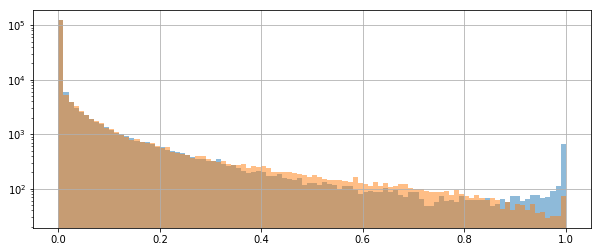

In [284]:
pd.Series(normalize(W, axis=0, norm='l1').flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))
pd.Series(normalize(W1, axis=1, norm='l1').flatten()).hist(bins=100, alpha=0.5)

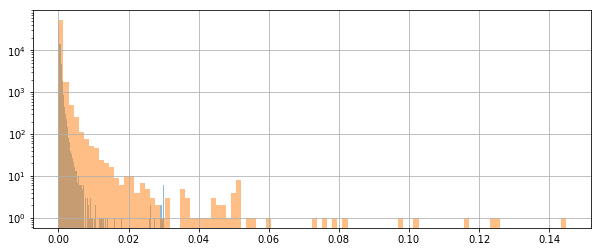

In [286]:
pd.Series(A.flatten()).hist(bins=100, log=True, alpha=0.5, figsize=(10,4))
pd.Series(normalize(H1, axis=1, norm='l1').flatten()).hist(bins=100, alpha=0.5)